# Surface Runoff
This script uses Version 5 of the 'Streams, Outlets, Basins, and Discharge [k=1.0]' dataset (Mankoff et al., 2020) provided on the GEUS dataverse. For details regarding this dataset, please visit: https://doi.org/10.22008/FK2/XKQVL7. It should be noted that as Jakobshavn Isbrae is a marine-terminating glacier, only the 'ice' datasets are downloaded (the 'land' files are not needed). 

In [1]:
# IMPORT MODULES [freshwater_discharge environment]
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime, timedelta

In [2]:
# DEFINE THE RACMO AND MAR DATASETS
racmo_ds = xr.open_dataset('R:/JAKOBSHAVN/DATA/surface_runoff/ken_mankoff/freshwater/ice/RACMO.nc')
mar_ds = xr.open_dataset('R:/JAKOBSHAVN/DATA/surface_runoff/ken_mankoff/freshwater/ice/MAR.nc')

In [3]:
# DEFINE THE STATION_ID [OUTLET ID] FOR JAKOBSHAVN ISBRAE 
station_id = 62369
racmo_discharge_timeseries = racmo_ds['discharge'].sel(station=station_id)
mar_discharge_timeseries = mar_ds['discharge'].sel(station=station_id)

# Data Analysis (2018-2023)

The following block slices both the RACMO and MAR discharge timeseries between a specified start and end date (2018-2023). The data is then resampled to produce a timeseries of cumulative daily and yearly runoff.

In [4]:
# DEFINE THE START AND END DATE FOR THE TIMESERIES (2018-2023)
start_date = '2018-01-01'
end_date = '2022-12-31'

# CALCULATE THE CUMULATIVE ANNUAL RUNOFF FROM THE RACMO DATA
racmo_discharge_timeseries = racmo_discharge_timeseries.sel(time=slice(start_date, end_date))
racmo_cumulative_volume_daily = racmo_discharge_timeseries * 86400 # Convert m3/s to m3/day
racmo_cumulative_volume_yearly = racmo_cumulative_volume_daily.resample(time='Y').sum()

# CALCULATE THE CUMULATIVE ANNUAL RUNOFF FROM THE MAR DATA
mar_discharge_timeseries = mar_discharge_timeseries.sel(time=slice(start_date, end_date))
mar_cumulative_volume_daily = mar_discharge_timeseries * 86400
mar_cumulative_volume_yearly = mar_cumulative_volume_daily.resample(time='Y').sum()

The following block produces a figure with two sub-plots. The first plot shows the daily cumulative runoff (RACMO & MAR), whilst the second plot shows the yearly cumulative runoff (RACMO & MAR).

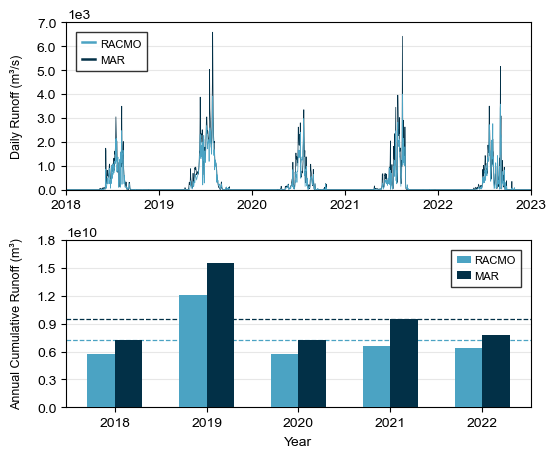

In [5]:
# INITIALISE A FIGURE WITH TWO SUBPLOTS AND GRID LINES SHOWN
plt.rcParams["font.family"] = "Arial"
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5))
plt.subplots_adjust(hspace=0.3) 
ax1.grid(axis='y', alpha=0.3, zorder=0)
ax2.grid(axis='y', alpha=0.3, zorder=0)
bar_width = 0.3

# # PLOT 1 - DAILY RUNOFF (2018-2023) FROM RACMO AND MAR # # 
ax1.plot(mar_discharge_timeseries['time'], mar_discharge_timeseries.values/1000, label='MAR', linewidth=0.5, color='#023047')
ax1.plot(racmo_discharge_timeseries['time'], racmo_discharge_timeseries.values/1000, label='RACMO', linewidth=0.5, color='#4ba3c3')

# FORMAT THE Y-AXIS TICKS AND TITLE
ax1.set_ylim(0, 7)
y_ticks = np.arange(0, 7 + 1, 1)
y_ticks_with_decimal = [f'{val:.1f}' for val in y_ticks]
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_ticks_with_decimal)
ax1.annotate("1e3", xy=(0.0025, 1.025), xycoords="axes fraction", fontsize=10, color="black")
ax1.set_ylabel('Daily Runoff (m³/s)', labelpad=10, fontsize=9)

# FORMAT THE X-AXIS TICKS
min_x_value = pd.to_datetime('2018-01-01', format='%Y-%m-%d')
max_x_value = pd.to_datetime('2023-01-01', format='%Y-%m-%d')
ax1.set_xlim(min_x_value, max_x_value)

# FORMAT THE LEGEND 
handles, labels = ax1.get_legend_handles_labels()
handles = handles[::-1] # Reverse order so RACMO is labelled first
labels = labels[::-1]
ax1.legend(handles, labels, handlelength=1.2, handleheight=1, handletextpad=0.5, frameon=True, borderpad=0.5, borderaxespad=0.9, markerscale=4, fontsize=8, fancybox=False)
for line in ax1.get_legend().get_lines():
    line.set_linewidth(1.8)
ax1.get_legend().get_frame().set_edgecolor('black')
ax1.get_legend().get_frame().set_linewidth(1)

# # PLOT 2 - ANNUAL CUMULATIVE RUNOFF (2018-2023) FROM RACMO AND MAR # # 
years = [2018, 2019, 2020, 2021, 2022]
racmo_positions = np.arange(len(years))
ax2.bar(racmo_positions - bar_width / 2, racmo_cumulative_volume_yearly, width=bar_width, color='#4ba3c3', zorder=20, label='RACMO')
mar_positions = np.arange(len(years))
ax2.bar(mar_positions + bar_width / 2, mar_cumulative_volume_yearly, width=bar_width, zorder=20, color='#023047', label='MAR')

# FORMAT THE Y-AXIS TICKS AND TITLE
ax2.set_ylim(0, 1.8e10)
ax2.set_yticks(np.arange(0, 1.8e10 + 2e9, 3e9))
ax2.set_ylabel('Annual Cumulative Runoff (m³)', labelpad=10, fontsize=9)
ax2.set_xticks(mar_positions)
ax2.set_xticklabels(years)
ax2.set_xlabel('Year', labelpad=5, fontsize=10)
ax2.tick_params(labelsize=10)

# FORMAT THE LEGEND
legend = ax2.legend(handlelength=1.3, handletextpad=0.25, frameon=True, borderpad=0.5, borderaxespad=0.9, markerscale=1, fontsize=8, fancybox=False)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1)

# ADD HORIZONTAL LINES SHOWING THE MEAN ANNUAL CUMULATIVE RUNOFF
mean_mar_cumulative = np.mean(mar_cumulative_volume_yearly)
mean_racmo_cumulative = np.mean(racmo_cumulative_volume_yearly)
ax2.axhline(mean_racmo_cumulative, color='#4ba3c3', linestyle='--', label=f'Mean RACMO ({mean_racmo_cumulative:.2e} m³)', linewidth=0.9)
ax2.axhline(mean_mar_cumulative, color='#023047', linestyle='--', label=f'Mean MAR ({mean_mar_cumulative:.2e} m³)', linewidth=0.9)

The following block calculates some basic statistics from the data shown above. To begin, the minimum and maximum daily runoff values are calculated from both the MAR AND RACMO datasets.

In [6]:
# EXTRACT BASIC STATISTICS ABOUT RACMO (DAILY)
racmo_max_daily_runoff = racmo_discharge_timeseries.max(dim='time')
racmo_date_of_max_runoff = racmo_discharge_timeseries.time[racmo_discharge_timeseries.argmax(dim='time')]
timestamp_max_racmo = racmo_date_of_max_runoff.item()
date_max_racmo = datetime.fromtimestamp(timestamp_max_racmo / 1e9)
racmo_max_runoff_value = racmo_max_daily_runoff.item()
print(f"The maximum daily runoff estimated by RACMO was {racmo_max_runoff_value} m³/s, on {date_max_racmo.strftime('%Y-%m-%d %H:%M:%S')[:10]}")

racmo_min_daily_runoff = racmo_discharge_timeseries.min(dim='time')
racmo_date_of_min_runoff = racmo_discharge_timeseries.time[racmo_discharge_timeseries.argmin(dim='time')]
timestamp_min_racmo = racmo_date_of_min_runoff.item()
date_min_racmo = datetime.fromtimestamp(timestamp_min_racmo / 1e9)
min_runoff_value = racmo_min_daily_runoff.item()
print(f"The minimum daily runoff estimated by RACMO was {min_runoff_value} m³/s, on {date_min_racmo.strftime('%Y-%m-%d %H:%M:%S')[:10]}")
print()

# EXTRACT BASIC STATISTICS ABOUT MAR (DAILY)
mar_max_daily_runoff = mar_discharge_timeseries.max(dim='time')
date_of_max_runoff_mar = mar_discharge_timeseries.time[mar_discharge_timeseries.argmax(dim='time')]
timestamp_max_mar = date_of_max_runoff_mar.item()
date_max_mar = datetime.fromtimestamp(timestamp_max_mar / 1e9)
max_runoff_value_mar = mar_max_daily_runoff.item()
print(f"The maximum daily runoff estimated by MAR was {max_runoff_value_mar} m³/s, on {date_max_mar.strftime('%Y-%m-%d %H:%M:%S')[:10]}")

mar_min_daily_runoff = mar_discharge_timeseries.min(dim='time')
date_of_min_runoff_mar = mar_discharge_timeseries.time[mar_discharge_timeseries.argmin(dim='time')]
timestamp_min_mar = date_of_min_runoff_mar.item()
date_min_mar = datetime.fromtimestamp(timestamp_min_mar / 1e9)
min_runoff_value_mar = mar_min_daily_runoff.item()
print(f"The minimum daily runoff estimated by MAR was {min_runoff_value_mar} m³/s, on {date_min_mar.strftime('%Y-%m-%d %H:%M:%S')[:10]}")


The maximum daily runoff estimated by RACMO was 4002.0189451430056 m³/s, on 2021-08-14
The minimum daily runoff estimated by RACMO was 0.013977969475473756 m³/s, on 2020-11-19

The maximum daily runoff estimated by MAR was 6588.706377028618 m³/s, on 2019-07-31
The minimum daily runoff estimated by MAR was 0.0008587795308356383 m³/s, on 2019-01-06


Next, the second and third highest rates of daily runoff are calculated and printed for both RACMO and MAR.

In [23]:
# CALCULATE AND PRINT THE SECOND AND THIRD PEAK RUNOFF (RACMO)
max_index_racmo = np.argmax(racmo_discharge_timeseries.values)
top_5_indices_racmo = np.argsort(racmo_discharge_timeseries.values)
second_max_index_racmo = top_5_indices_racmo[-2]
second_max_value_racmo = racmo_discharge_timeseries.values[second_max_index_racmo]
second_max_date_racmo = racmo_discharge_timeseries.time.values[second_max_index_racmo].astype('M8[s]').astype(datetime)
third_max_index_racmo = top_5_indices_racmo[-3]
third_max_value_racmo = racmo_discharge_timeseries.values[third_max_index_racmo]
third_max_date_racmo = racmo_discharge_timeseries.time.values[third_max_index_racmo].astype('M8[s]').astype(datetime)
print(f"The second maximum daily runoff by RACMO was {second_max_value_racmo} m³/s, on {second_max_date_racmo.strftime('%Y-%m-%d')}")
print(f"The third maximum daily runoff by RACMO was {third_max_value_racmo} m³/s, on {third_max_date_racmo.strftime('%Y-%m-%d')}")
print()

# CALCULATE AND PRINT THE SECOND AND THIRD PEAK RUNOFF (MAR)
max_index = np.argmax(mar_discharge_timeseries.values)
top_5_indices_mar = np.argsort(mar_discharge_timeseries.values)
second_max_index = top_5_indices_mar[-2]
second_max_value = mar_discharge_timeseries.values[second_max_index]
second_max_date = mar_discharge_timeseries.time.values[second_max_index].astype('M8[s]').astype(datetime)
third_max_index = top_5_indices_mar[-3]
third_max_value = mar_discharge_timeseries.values[third_max_index]
third_max_date = mar_discharge_timeseries.time.values[third_max_index].astype('M8[s]').astype(datetime)
print(f"The second maximum daily runoff by MAR was {second_max_value} m³/s, on {second_max_date.strftime('%Y-%m-%d')}")
print(f"The third maximum daily runoff by MAR was {third_max_value} m³/s, on {third_max_date.strftime('%Y-%m-%d')}")

The second maximum daily runoff by RACMO was 3918.7187839164776 m³/s, on 2019-07-31
The third maximum daily runoff by RACMO was 3582.4805751609083 m³/s, on 2022-09-03

The second maximum daily runoff by MAR was 6418.045364278518 m³/s, on 2021-08-14
The third maximum daily runoff by MAR was 5157.203270953357 m³/s, on 2022-09-03


Print a table showing the annual cumulative runoff for each year. Then, calculate the percentage change in annual cumulative runoff from 2018 to 2019 for both RACMO and MAR.

In [8]:
# CREATE A DATAFRAME SHOWING ANNUAL CUMULATIVE RUNOFF (RACMO & MAR)
data = {'Year': years, 'RACMO (m³)': racmo_cumulative_volume_yearly, 'MAR (m³)': mar_cumulative_volume_yearly}
df = pd.DataFrame(data)
print(df)
print()

# CALCULATE PERCENTAGE CHANGE FROM 2018 TO 2019.
racmo_2018 = racmo_cumulative_volume_yearly[0]
racmo_2019 = racmo_cumulative_volume_yearly[1]
mar_2018 = mar_cumulative_volume_yearly[0]
mar_2019 = mar_cumulative_volume_yearly[1]
percentage_change_racmo = ((racmo_2019 - racmo_2018) / racmo_2018) * 100
percentage_change_mar = ((mar_2019 - mar_2018) / mar_2018) * 100
print(f"Percentage Change from 2018 to 2019 (RACMO): {percentage_change_racmo:.2f}%")
print(f"Percentage Change from 2018 to 2019 (MAR): {percentage_change_mar:.2f}%")

   Year    RACMO (m³)      MAR (m³)
0  2018  5.752071e+09  7.259746e+09
1  2019  1.204924e+10  1.552838e+10
2  2020  5.691500e+09  7.231175e+09
3  2021  6.584036e+09  9.542633e+09
4  2022  6.331770e+09  7.801078e+09

Percentage Change from 2018 to 2019 (RACMO): 109.48%
Percentage Change from 2018 to 2019 (MAR): 113.90%
